# Gráficos de Cleveland: Diferencias en Tiempo entre Generales y Ballotage

Este notebook genera **gráficos de Cleveland (Cleveland dot plots)** para visualizar las diferencias en Cambio de Tiempo (CT) entre candidatos de Izquierda y Derecha, comparando Generales vs Ballotage.

## Concepto:

Para cada ítem mostramos:
- **Punto azul (●)**: Diferencia Izq-Der en **Generales** (Dif_Gen_CT)
- **Punto rojo (●)**: Diferencia Izq-Der en **Ballotage** (Dif_Bal_CT)
- **Línea conectando**: Muestra el cambio entre elecciones
- **Color de línea**:
  - Verde: Diferencia aumentó en Ballotage (más positivo)
  - Gris: Cambio pequeño (≤ 0.5 segundos)
  - Naranja: Diferencia disminuyó en Ballotage (más negativo)

## Interpretación:

- **Valores positivos**: Mayor tiempo en candidatos de Izquierda
- **Valores negativos**: Mayor tiempo en candidatos de Derecha
- **Línea hacia la derecha**: La diferencia aumentó en Ballotage
- **Línea hacia la izquierda**: La diferencia disminuyó en Ballotage

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Librerías cargadas exitosamente')

✓ Librerías cargadas exitosamente


## 1. Cargar Datos

In [12]:
# Ruta al archivo
Ruta_Base = os.path.join(os.getcwd(), '..', 'Data', 'Procesados')
Archivo_Elecciones = os.path.join(Ruta_Base, 'df_Elecciones.xlsx')

# Cargar datos
df_Elecciones = pd.read_excel(Archivo_Elecciones)

print(f'✓ Datos cargados:')
print(f'  - {len(df_Elecciones)} registros')
print(f'  - {len(df_Elecciones.columns)} columnas')

# Verificar que tenemos las columnas necesarias
columnas_dif_gen = [col for col in df_Elecciones.columns if col.startswith('Dif_Gen_CT')]
columnas_dif_bal = [col for col in df_Elecciones.columns if col.startswith('Dif_Bal_CT')]

print(f'\n  - Variables Dif_Gen_CT: {len(columnas_dif_gen)}')
print(f'  - Variables Dif_Bal_CT: {len(columnas_dif_bal)}')

✓ Datos cargados:
  - 2786 registros
  - 138 columnas

  - Variables Dif_Gen_CT: 20
  - Variables Dif_Bal_CT: 20


## 2. Preparar Datos para Gráfico

In [13]:
# Definir ítems
Items_Progresistas = [5, 6, 9, 11, 16, 20, 24, 25, 27, 28]
Items_Conservadores = [3, 4, 7, 8, 10, 19, 22, 23, 29, 30]
Todos_Items = sorted(Items_Progresistas + Items_Conservadores)

print(f'Total de ítems: {len(Todos_Items)}')
print(f'Ítems: {Todos_Items}')

# Calcular promedios y significancia por ítem
datos_grafico = []

for item in Todos_Items:
    var_gen = f'Dif_Gen_CT_Item_{item}'
    var_bal = f'Dif_Bal_CT_Item_{item}'
    
    if var_gen in df_Elecciones.columns and var_bal in df_Elecciones.columns:
        # Calcular promedios (ignorando NaN)
        media_gen = df_Elecciones[var_gen].mean()
        media_bal = df_Elecciones[var_bal].mean()
        
        # Calcular cambio
        cambio = media_bal - media_gen
        
        # Test t pareado para significancia
        datos_pareados = df_Elecciones[[var_gen, var_bal]].dropna()
        if len(datos_pareados) > 1:
            t_stat, p_valor = stats.ttest_rel(datos_pareados[var_bal], datos_pareados[var_gen])
            
            # Determinar asteriscos de significancia
            if p_valor < 0.001:
                sig = '***'
            elif p_valor < 0.01:
                sig = '**'
            elif p_valor < 0.05:
                sig = '*'
            else:
                sig = ''
        else:
            p_valor = 1.0
            sig = ''
        
        # Determinar tipo de ítem
        tipo = 'Progresista' if item in Items_Progresistas else 'Conservador'
        
        datos_grafico.append({
            'Item': item,
            'Tipo': tipo,
            'Dif_Generales': media_gen,
            'Dif_Ballotage': media_bal,
            'Cambio': cambio,
            'p_valor': p_valor,
            'Significancia': sig
        })

# Crear DataFrame
df_grafico = pd.DataFrame(datos_grafico)

print(f'\n✓ Datos preparados para {len(df_grafico)} ítems')
print(f'\nPrimeras filas:')
print(df_grafico.head(10))

Total de ítems: 20
Ítems: [3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30]

✓ Datos preparados para 20 ítems

Primeras filas:
   Item         Tipo  Dif_Generales  Dif_Ballotage    Cambio   p_valor  \
0     3  Conservador      -0.749074       0.238225  0.987299  0.380038   
1     4  Conservador      -0.120798       0.335359  0.456157  0.342856   
2     5  Progresista      -0.220871       0.601248  0.822120  0.023790   
3     6  Progresista      -0.878414      -0.965284 -0.086869  0.965625   
4     7  Conservador      -0.128609      -0.412769 -0.284159  0.052712   
5     8  Conservador      -0.332815       0.585377  0.918192  0.857389   
6     9  Progresista      -0.994499       0.070597  1.065096  0.573077   
7    10  Conservador      -0.145863       0.449719  0.595583  0.187674   
8    11  Progresista      -1.093299      -0.355252  0.738047  0.102573   
9    16  Progresista      -0.477988      -0.491099 -0.013111  0.480885   

  Significancia  
0               

## 3. Función para Crear Gráfico de Cleveland

In [14]:
def Crear_Grafico_Cleveland(df, titulo, nombre_archivo=None, carpeta_destino='Graficos_Cleveland'):
    """
    Crea un gráfico de Cleveland mostrando diferencias Gen vs Bal.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con columnas: Item, Dif_Generales, Dif_Ballotage, Cambio, Significancia
    titulo : str
        Título del gráfico
    nombre_archivo : str, optional
        Nombre del archivo (sin extensión)
    carpeta_destino : str
        Carpeta donde guardar
    """
    
    # Crear carpeta si no existe
    if not os.path.exists(carpeta_destino):
        os.makedirs(carpeta_destino)
    
    # Ordenar por cambio (descendente)
    df_sorted = df.sort_values('Cambio', ascending=True).reset_index(drop=True)
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Parámetros visuales
    y_positions = np.arange(len(df_sorted))
    
    # Dibujar líneas conectando los puntos
    for idx, row in df_sorted.iterrows():
        gen_val = row['Dif_Generales']
        bal_val = row['Dif_Ballotage']
        cambio = row['Cambio']
        
        # Determinar color de línea según cambio
        if cambio > 0.5:  # Aumentó
            color_linea = '#2ecc71'  # Verde
            alpha = 0.6
        elif cambio < -0.5:  # Disminuyó
            color_linea = '#e74c3c'  # Rojo/Naranja
            alpha = 0.6
        else:  # Cambio pequeño
            color_linea = '#95a5a6'  # Gris
            alpha = 0.3
        
        # Dibujar línea
        ax.plot([gen_val, bal_val], [idx, idx], 
                color=color_linea, linewidth=1.5, alpha=alpha, zorder=1)
    
    # Dibujar puntos de Generales
    ax.scatter(df_sorted['Dif_Generales'], y_positions, 
               s=120, c='#3498db', marker='o', 
               edgecolors='white', linewidths=1.5,
               label='Generales', zorder=3, alpha=0.8)
    
    # Dibujar puntos de Ballotage
    ax.scatter(df_sorted['Dif_Ballotage'], y_positions, 
               s=120, c='#e74c3c', marker='o', 
               edgecolors='white', linewidths=1.5,
               label='Ballotage', zorder=3, alpha=0.8)
    
    # Línea vertical en x=0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.3, zorder=0)
    
    # Configurar ejes
    ax.set_yticks(y_positions)
    
    # Agregar asteriscos de significancia a las etiquetas del eje Y
    labels_y = []
    for _, row in df_sorted.iterrows():
        etiqueta = f"Ítem {int(row['Item'])}"
        if row['Significancia']:
            etiqueta += f" {row['Significancia']}"
        labels_y.append(etiqueta)
    
    ax.set_yticklabels(labels_y, fontsize=10)
    
    ax.set_xlabel('Diferencia Izq - Der (segundos)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ítem', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True, axis='x', alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Leyenda personalizada
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
               markersize=10, label='Generales', markeredgecolor='white', markeredgewidth=1),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
               markersize=10, label='Ballotage', markeredgecolor='white', markeredgewidth=1),
        Line2D([0], [0], color='#2ecc71', linewidth=2, label='Aumentó (>0.5s)'),
        Line2D([0], [0], color='#95a5a6', linewidth=2, label='Sin cambio (±0.5s)'),
        Line2D([0], [0], color='#e74c3c', linewidth=2, label='Disminuyó (<-0.5s)'),
        Line2D([0], [0], linestyle='', marker='', label='* p<0.05  ** p<0.01  *** p<0.001')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
              framealpha=0.95, edgecolor='gray')
    
    # Ajustar layout
    plt.tight_layout()
    
    # Guardar
    if nombre_archivo:
        ruta_completa = os.path.join(carpeta_destino, f'{nombre_archivo}.png')
        plt.savefig(ruta_completa, dpi=300, bbox_inches='tight', facecolor='white')
        print(f'✅ Gráfico guardado: {ruta_completa}')
    
    plt.show()
    
    return fig, ax

## 4. Gráfico Principal: Todos los Ítems

✅ Gráfico guardado: Graficos_Cleveland\Cleveland_CT_Todos_Items.png


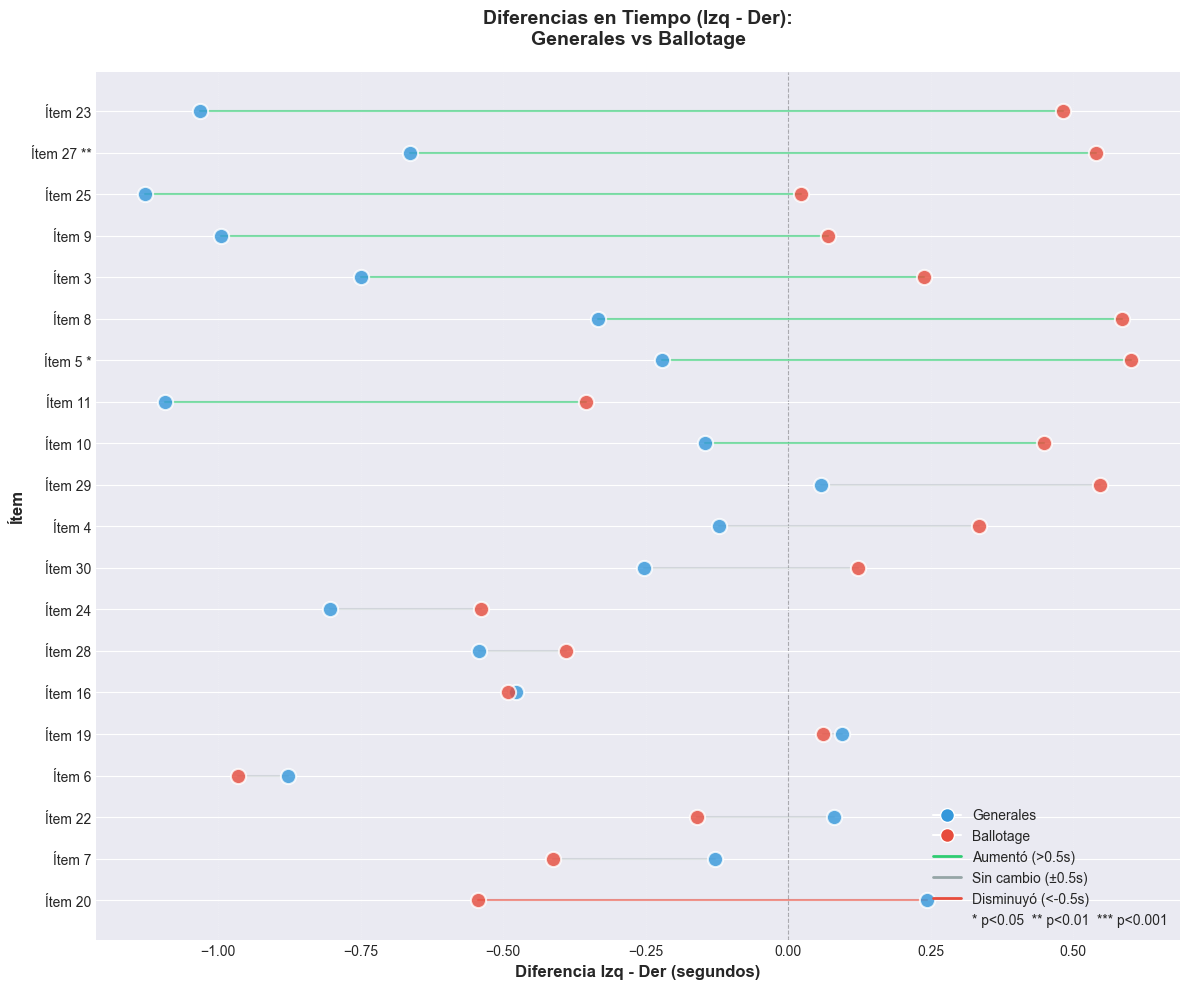

In [15]:
# Crear gráfico principal
fig, ax = Crear_Grafico_Cleveland(
    df_grafico,
    titulo='Diferencias en Tiempo (Izq - Der):\nGenerales vs Ballotage',
    nombre_archivo='Cleveland_CT_Todos_Items'
)

## 5. Análisis Estadístico de Cambios

In [16]:
print('='*70)
print('ANÁLISIS DE CAMBIOS ENTRE GENERALES Y BALLOTAGE')
print('='*70)

print(f'\n📊 Estadísticas Generales:')
print(f'  Promedio Dif_Generales: {df_grafico["Dif_Generales"].mean():.3f} seg')
print(f'  Promedio Dif_Ballotage: {df_grafico["Dif_Ballotage"].mean():.3f} seg')
print(f'  Promedio Cambio: {df_grafico["Cambio"].mean():.3f} seg')

print(f'\n📈 Distribución de Cambios:')
aumentaron = len(df_grafico[df_grafico['Cambio'] > 0.5])
sin_cambio = len(df_grafico[(df_grafico['Cambio'] >= -0.5) & (df_grafico['Cambio'] <= 0.5)])
disminuyeron = len(df_grafico[df_grafico['Cambio'] < -0.5])

print(f'  Aumentaron (>0.5s): {aumentaron} ítems ({aumentaron/len(df_grafico)*100:.1f}%)')
print(f'  Sin cambio (±0.5s): {sin_cambio} ítems ({sin_cambio/len(df_grafico)*100:.1f}%)')
print(f'  Disminuyeron (<-0.5s): {disminuyeron} ítems ({disminuyeron/len(df_grafico)*100:.1f}%)')

print(f'\n🏆 Top 5 Ítems con MAYOR Aumento:')
print('-'*70)
top_aumento = df_grafico.nlargest(5, 'Cambio')[['Item', 'Tipo', 'Dif_Generales', 'Dif_Ballotage', 'Cambio']]
print(top_aumento.to_string(index=False))

print(f'\n🏆 Top 5 Ítems con MAYOR Disminución:')
print('-'*70)
top_disminucion = df_grafico.nsmallest(5, 'Cambio')[['Item', 'Tipo', 'Dif_Generales', 'Dif_Ballotage', 'Cambio']]
print(top_disminucion.to_string(index=False))

print('\n' + '='*70)

ANÁLISIS DE CAMBIOS ENTRE GENERALES Y BALLOTAGE

📊 Estadísticas Generales:
  Promedio Dif_Generales: -0.454 seg
  Promedio Dif_Ballotage: 0.010 seg
  Promedio Cambio: 0.464 seg

📈 Distribución de Cambios:
  Aumentaron (>0.5s): 9 ítems (45.0%)
  Sin cambio (±0.5s): 10 ítems (50.0%)
  Disminuyeron (<-0.5s): 1 ítems (5.0%)

🏆 Top 5 Ítems con MAYOR Aumento:
----------------------------------------------------------------------
 Item        Tipo  Dif_Generales  Dif_Ballotage   Cambio
   23 Conservador      -1.032548       0.482522 1.515070
   27 Progresista      -0.663653       0.540637 1.204290
   25 Progresista      -1.127731       0.022642 1.150373
    9 Progresista      -0.994499       0.070597 1.065096
    3 Conservador      -0.749074       0.238225 0.987299

🏆 Top 5 Ítems con MAYOR Disminución:
----------------------------------------------------------------------
 Item        Tipo  Dif_Generales  Dif_Ballotage    Cambio
   20 Progresista       0.244440      -0.544897 -0.789337
    7 

## 5.1. Análisis de Significancia Estadística

In [17]:
print('='*70)
print('ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA')
print('='*70)

# Contar ítems significativos
sig_items = df_grafico[df_grafico['Significancia'] != '']
print(f'\n📊 Resultados:')
print(f'  Total de ítems analizados: {len(df_grafico)}')
print(f'  Ítems con diferencia significativa: {len(sig_items)} ({len(sig_items)/len(df_grafico)*100:.1f}%)')

if len(sig_items) > 0:
    print(f'\n📈 Desglose por nivel de significancia:')
    n_p001 = len(df_grafico[df_grafico['Significancia'] == '***'])
    n_p01 = len(df_grafico[df_grafico['Significancia'] == '**'])
    n_p05 = len(df_grafico[df_grafico['Significancia'] == '*'])
    
    print(f'  *** (p < 0.001): {n_p001} ítems')
    print(f'  **  (p < 0.01):  {n_p01} ítems')
    print(f'  *   (p < 0.05):  {n_p05} ítems')
    
    print(f'\n🏆 Ítems con diferencias significativas:')
    print('-'*70)
    sig_sorted = sig_items.sort_values('p_valor')[['Item', 'Tipo', 'Cambio', 'p_valor', 'Significancia']]
    for idx, row in sig_sorted.iterrows():
        print(f"  Ítem {int(row['Item']):2d} ({row['Tipo']:12s}): Cambio = {row['Cambio']:6.3f}s, p = {row['p_valor']:.4f} {row['Significancia']}")
else:
    print('\n  ⚠️  Ningún ítem mostró diferencias significativas')

print('\n' + '='*70)

ANÁLISIS DE SIGNIFICANCIA ESTADÍSTICA

📊 Resultados:
  Total de ítems analizados: 20
  Ítems con diferencia significativa: 2 (10.0%)

📈 Desglose por nivel de significancia:
  *** (p < 0.001): 0 ítems
  **  (p < 0.01):  1 ítems
  *   (p < 0.05):  1 ítems

🏆 Ítems con diferencias significativas:
----------------------------------------------------------------------
  Ítem 27 (Progresista ): Cambio =  1.204s, p = 0.0038 **
  Ítem  5 (Progresista ): Cambio =  0.822s, p = 0.0238 *



## 6. Comparación por Tipo de Ítem

In [18]:
print('='*70)
print('COMPARACIÓN: ÍTEMS PROGRESISTAS vs CONSERVADORES')
print('='*70)

# Agrupar por tipo
por_tipo = df_grafico.groupby('Tipo').agg({
    'Dif_Generales': ['mean', 'std'],
    'Dif_Ballotage': ['mean', 'std'],
    'Cambio': ['mean', 'std'],
    'Item': 'count'
}).round(3)

print('\n📊 Estadísticas por Tipo:')
print(por_tipo)

print('\n💡 Interpretación:')
cambio_prog = df_grafico[df_grafico['Tipo'] == 'Progresista']['Cambio'].mean()
cambio_cons = df_grafico[df_grafico['Tipo'] == 'Conservador']['Cambio'].mean()

print(f'\n  Ítems Progresistas:')
print(f'    - Cambio promedio: {cambio_prog:.3f} seg')
if cambio_prog > 0:
    print(f'    - En Ballotage aumentó la diferencia Izq-Der')
else:
    print(f'    - En Ballotage disminuyó la diferencia Izq-Der')

print(f'\n  Ítems Conservadores:')
print(f'    - Cambio promedio: {cambio_cons:.3f} seg')
if cambio_cons > 0:
    print(f'    - En Ballotage aumentó la diferencia Izq-Der')
else:
    print(f'    - En Ballotage disminuyó la diferencia Izq-Der')

print('\n' + '='*70)

COMPARACIÓN: ÍTEMS PROGRESISTAS vs CONSERVADORES

📊 Estadísticas por Tipo:
            Dif_Generales        Dif_Ballotage        Cambio         Item
                     mean    std          mean    std   mean    std count
Tipo                                                                     
Conservador        -0.253  0.370         0.225  0.326  0.478  0.569    10
Progresista        -0.656  0.427        -0.205  0.503  0.451  0.651    10

💡 Interpretación:

  Ítems Progresistas:
    - Cambio promedio: 0.451 seg
    - En Ballotage aumentó la diferencia Izq-Der

  Ítems Conservadores:
    - Cambio promedio: 0.478 seg
    - En Ballotage aumentó la diferencia Izq-Der



## 7. Guardar Tabla Resumen

In [19]:
# Crear carpeta de salida
Carpeta_Salida = os.path.join(os.getcwd(), '..', 'Data', 'Resultados_Cleveland')
if not os.path.exists(Carpeta_Salida):
    os.makedirs(Carpeta_Salida)

# Guardar tabla de datos
Archivo_Salida = os.path.join(Carpeta_Salida, 'Resumen_Diferencias_CT.xlsx')
df_grafico_export = df_grafico.copy()
df_grafico_export.to_excel(Archivo_Salida, index=False)

print(f'✅ Tabla resumen guardada: {Archivo_Salida}')
print(f'   {len(df_grafico_export)} ítems × {len(df_grafico_export.columns)} columnas')

✅ Tabla resumen guardada: c:\Users\Patricio\Documents\Codigo\Python\Investigacion\Tesis\Código\..\Data\Resultados_Cleveland\Resumen_Diferencias_CT.xlsx
   20 ítems × 7 columnas


## 8. Resumen Final

In [20]:
print('='*70)
print('RESUMEN: GRÁFICOS DE CLEVELAND - DIFERENCIAS EN TIEMPO')
print('='*70)

print('\n📊 Análisis completado:')
print(f'  - Ítems analizados: {len(df_grafico)}')
print(f'  - Gráficos generados: 1 (Cleveland plot)')
print(f'  - Comparación: Generales vs Ballotage')

print('\n📁 Archivos generados:')
print('  - Cleveland_CT_Todos_Items.png (gráfico principal)')
print('  - Resumen_Diferencias_CT.xlsx (tabla de datos)')

print('\n🎯 Hallazgos clave:')
print(f'  - {aumentaron} ítems mostraron aumento en diferencia Izq-Der')
print(f'  - {disminuyeron} ítems mostraron disminución')
print(f'  - {sin_cambio} ítems sin cambio sustancial')

print('\n💡 Interpretación:')
print('  - Valores positivos: Mayor tiempo dedicado a candidatos de Izquierda')
print('  - Valores negativos: Mayor tiempo dedicado a candidatos de Derecha')
print('  - Líneas verdes: La asimetría Izq-Der aumentó en Ballotage')
print('  - Líneas naranjas: La asimetría Izq-Der disminuyó en Ballotage')

print('\n' + '='*70)
print('✅ ANÁLISIS COMPLETADO')
print('='*70)

RESUMEN: GRÁFICOS DE CLEVELAND - DIFERENCIAS EN TIEMPO

📊 Análisis completado:
  - Ítems analizados: 20
  - Gráficos generados: 1 (Cleveland plot)
  - Comparación: Generales vs Ballotage

📁 Archivos generados:
  - Cleveland_CT_Todos_Items.png (gráfico principal)
  - Resumen_Diferencias_CT.xlsx (tabla de datos)

🎯 Hallazgos clave:
  - 9 ítems mostraron aumento en diferencia Izq-Der
  - 1 ítems mostraron disminución
  - 10 ítems sin cambio sustancial

💡 Interpretación:
  - Valores positivos: Mayor tiempo dedicado a candidatos de Izquierda
  - Valores negativos: Mayor tiempo dedicado a candidatos de Derecha
  - Líneas verdes: La asimetría Izq-Der aumentó en Ballotage
  - Líneas naranjas: La asimetría Izq-Der disminuyó en Ballotage

✅ ANÁLISIS COMPLETADO
